# Post processing plots

In [2]:
import lightkurve as lk
import astropy.table as astab
import pandas as pd
import numpy as np
import astropy
from astropy.coordinates import SkyCoord
from astropy import units as u
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from tqdm import tqdm
# %pylab inline
# pylab.rcParams['figure.figsize'] = (16, 8)
import warnings
import astropy.table as astab
from astropy.io import fits

warnings.filterwarnings('ignore',
    message="WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size:"
)
print(astropy.__version__)

import pickle as pk
import pymc3 as pm
import pymc3_ext as pmx
import aesara_theano_fallback.tensor as tt
from celerite2.theano import terms, GaussianProcess
import exoplanet as xo

import arviz as az
from corner import corner

from scipy.signal import savgol_filter
import wquantiles

# %matplotlib widget
dd = "/Users/kjaehnig/CCA_work/GAT/"

def docs_setup():
    """Set some environment variables and ignore some warnings for the docs"""
    import logging
    import warnings


    # Remove when Theano is updated
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    warnings.filterwarnings("ignore", category=FutureWarning)

    # Remove when arviz is updated
    warnings.filterwarnings("ignore", category=UserWarning)

    logger = logging.getLogger("theano.gof.compilelock")
    logger.setLevel(logging.ERROR)
    logger = logging.getLogger("theano.tensor.opt")
    logger.setLevel(logging.ERROR)
    logger = logging.getLogger("exoplanet")
    logger.setLevel(logging.DEBUG)

docs_setup()

import helper_functions as hf

4.3.1
running on macOS


In [11]:
def plot_residuals_of_models(TIC_TARGET=None,Ntune=1000, Ndraw=500, chains=4,
                                model_list=('diagonal','isotropized_isochrones','isochrones', 'diagonalized_isochrones')):

    fig,axes = plt.subplots(nrows=2,ncols=1,figsize=(16,8))    
    
    for ii,model_type in enumerate(model_list):
        file = open(f"/Users/kjaehnig/CCA_work/GAT/pymc3_models/{TIC_TARGET}_pymc3_Nt{Ntune}_Nd{Ndraw}_Nc{chains}_individual_priors_{model_type}_isochrones.pickle",'rb')
        indres = pk.load(file)
        file.close()
#         print(model_type)
#         pymc3dict = load_all_data_for_pymc3_model(TIC_TARGET,sparse_factor=5)
#         print(indres.keys())
        x,y = indres['lcdat']['x'],indres['lcdat']['y']
        x_rv, y_rv = indres['rvdat']['x_rv'],indres['rvdat']['y_rv']
              
        lcact = indres['lcact']
        rvact = indres['rvact']
        
#         with model:
#             gp_pred = (
#                 pmx.eval_in_model(extras['gp_lc_pred'], indres['map_soln'])
#                       )
            
        flat_samps = indres['trace'].posterior.stack(sample=("chain","draw"))
        p_med = np.median(flat_samps['period'])
        t0_med = np.median(flat_samps['t0'])
        
        xfold = hf.fold(x, p_med, t0_med)
        inds = np.argsort(xfold)
#         print(len(indres['mask']),len(y))
        y_min_gp_pred = y - indres['gp_pred']
        axes[0].plot(xfold[inds], y_min_gp_pred[inds] - np.median(lcact,axis=0)[indres['mask']][inds], c=f"C{ii*3}",zorder=ii,lw=0.5, label=model_type)


        y1,y2 = axes[0].set_ylim()
        maxY = max(abs(y1),abs(y2))
#         axes[0].set_ylim(-maxY, maxY)
        axes[0].axhline(0.0, ls='--', c='gray')

        xfold = hf.fold(x_rv, p_med, t0_med)
        inds = np.argsort(xfold)
        axes[1].plot(xfold[inds], y_rv[inds] - np.median(rvact,axis=0)[inds], c=f"C{ii*3}",zorder=ii,lw=3, label=model_type)
        y1,y2 = axes[1].set_ylim()
        maxY = max(abs(y1),abs(y2))
#         axes[1].set_ylim(-maxY, maxY)
        axes[1].axhline(0.0, ls='--', c='gray')
        

#         y_min_gp_pred = phased_res['lcDAT'][1] - phased_res['gp_pred']
#         xfold = fold(phased_res['lcDAT'][0], phased_res["POSTmed"]['p_med'], phased_res['POSTmed']['t0_med'])
#         inds = np.argsort(xfold)
#         axes[0].plot(xfold[inds], y_min_gp_pred[inds] - np.percentile(phased_res['lcact'],50,axis=0)[inds],c='red',lw=0.5, label='individual priors')

#         xfold = fold(phased_res['rvDAT'][0], phased_res['POSTmed']['p_med'], phased_res['POSTmed']['t0_med'])
#         inds = np.argsort(xfold)
#         axes[1].plot(xfold[inds], phased_res['rvDAT'][1][inds] - np.percentile(phased_res['rvact'],50,axis=0)[inds], c='red',lw=1)

        axes[0].set_ylim(min(y), max(y))
        axes[1].set_ylim(min(y_rv), max(y_rv))
        
        axes[0].set_ylabel("flux residuals [ppt]", fontsize=12)
        axes[1].set_ylabel("RV residuals [kms]", fontsize=12)
        axes[1].set_xlabel("phase [days]")
        axes[0].set_title(TIC_TARGET)
        axes[1].legend(fontsize=10, loc='best')

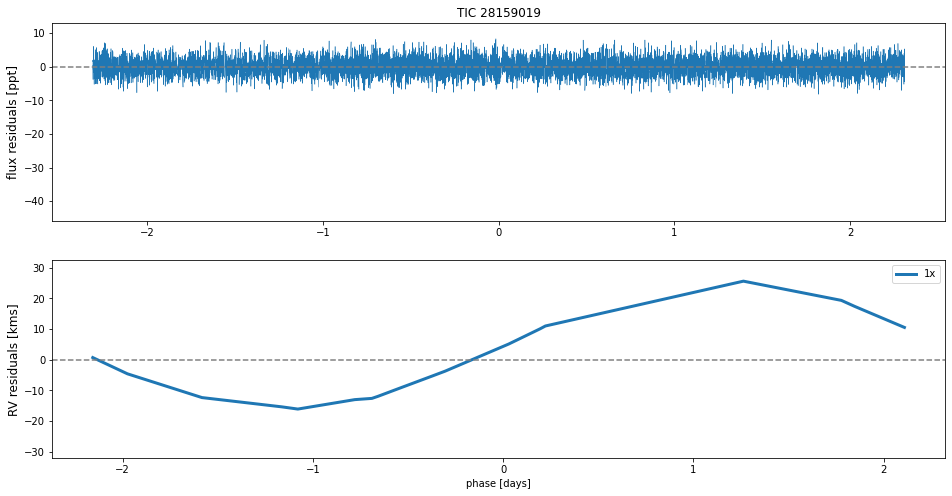

In [16]:
# from helper_functions import *
plot_target = 'TIC 28159019'
plot_residuals_of_models(plot_target,chains=6, model_list=['1x'],Ntune=1000, Ndraw=500)

In [17]:
def plot_all_model_corners(TIC_TARGET, Ntune=1000, Ndraw=500, chains=4,
                                model_list=['diagonal','isotropized_isochrones','isochrones', 'diagonalized_isochrones']):
    
    for ii, model_type in enumerate(model_list):
    
#     file = open(f"/Users/kjaehnig/CCA_work/GAT/pymc3_models/{TIC_TARGET}_pymc3_Nt{Ntune}_Nd{Ndraw}_Nc{chains}_IND.pickle",'rb')
#     ind_res_dict = pk.load(file)
#     file.close()
        try:
            xslabels = [r'$log{\rho}$', r'$logM_{1}$', r'$logR_{1}$', r'$logQ$', r'$logS$', r'$logK$','b',r'$t_{0}$', r'$t_{n}$']
            file = open(f"/Users/kjaehnig/CCA_work/GAT/pymc3_models/{TIC_TARGET}_pymc3_Nt{Ntune}_Nd{Ndraw}_Nc{chains}_individual_priors_{model_type}_isochrones.pickle",'rb')
            mv_res_dict = pk.load(file)
            file.close()

            MVtrace = mv_res_dict['trace']
            MVtrace.posterior['log_rho'] = np.log( MVtrace.posterior['M1'] / ( (4./3.) * np.pi * MVtrace.posterior['R1']**3.) )

            MVmapsoln = mv_res_dict['map_soln']
            MVmapsoln['log_rho'] = np.log( MVmapsoln['M1'] / ( (4./3.) * np.pi * MVmapsoln['R1']**3.) )
    #         INDtrace = ind_res_dict['trace']
            print(ii)
            if ii == 0:
                fig = corner(MVtrace, var_names=['log_rho','log_M1','log_R1','log_q','log_s','log_k','b','t0','tn'], smooth=1, use_math_text=True,
                  truths=MVmapsoln, labels=xslabels, labelpad=0.1, label_kwargs={'fontsize':16}, 
                   range=[1,1,1,1,1,1,1,1,1], color=f'C{ii*3}',label=model_type,
                        truth_color=f'C{ii*3}')

            if ii > 0:
                corner(MVtrace, var_names=['log_rho','log_M1','log_R1','log_q','log_s','log_k','b','t0','tn'], 
                   smooth=1, use_math_text=True, fig=fig, color=f'C{ii*3}',range=[1,1,1,1,1,1,1,1,1,], label=model_type,
                      labels=xslabels, labelpad=0.1, truths=MVmapsoln,truth_color=f'C{ii*3}')
                             
            fig.text(0.50,(75-ii*2.)/100.,model_type, color=f'C{ii*3}',fontsize=30)
        except:
            continue

# #     fig.text(0.50,0.74,'isotropized isochrones', color='C3', size=16)
# #     fig.text(0.5,0.73, 'isochrones', color='C6', size=16)
# #     fig.text(0.5,0.72, 'diagonalized isochrones', color='C9', size=16)
# #     fig.axes[0].set_title()
# flat_samps = trace.posterior.stack(sample=("chain", "draw"))
# # for data_var in flat_samps.data_vars.keys():
# #     print(data_var)
# plt.figure()



# # Get the posterior median orbital parameters
# p = np.median(flat_samps["period"])
# t0 = np.median(flat_samps["t0"])
# lcpred = np.percentile(flat_samps['lc_pred'], 50,axis=0)
# mod_phase = np.linspace(-.3, 0.3, len(lcpred))

# # Plot the folded data
# x_fold = (x[mask] - t0 + 0.5 * p) % p - 0.5 * p
# m = np.abs(x_fold) < 0.3
# plt.plot(
#     x_fold[m], y[mask][m] - np.std(lcpred), ".k", label="data", zorder=-1000
# )



# plt.plot(mod_phase, lcpred)

0


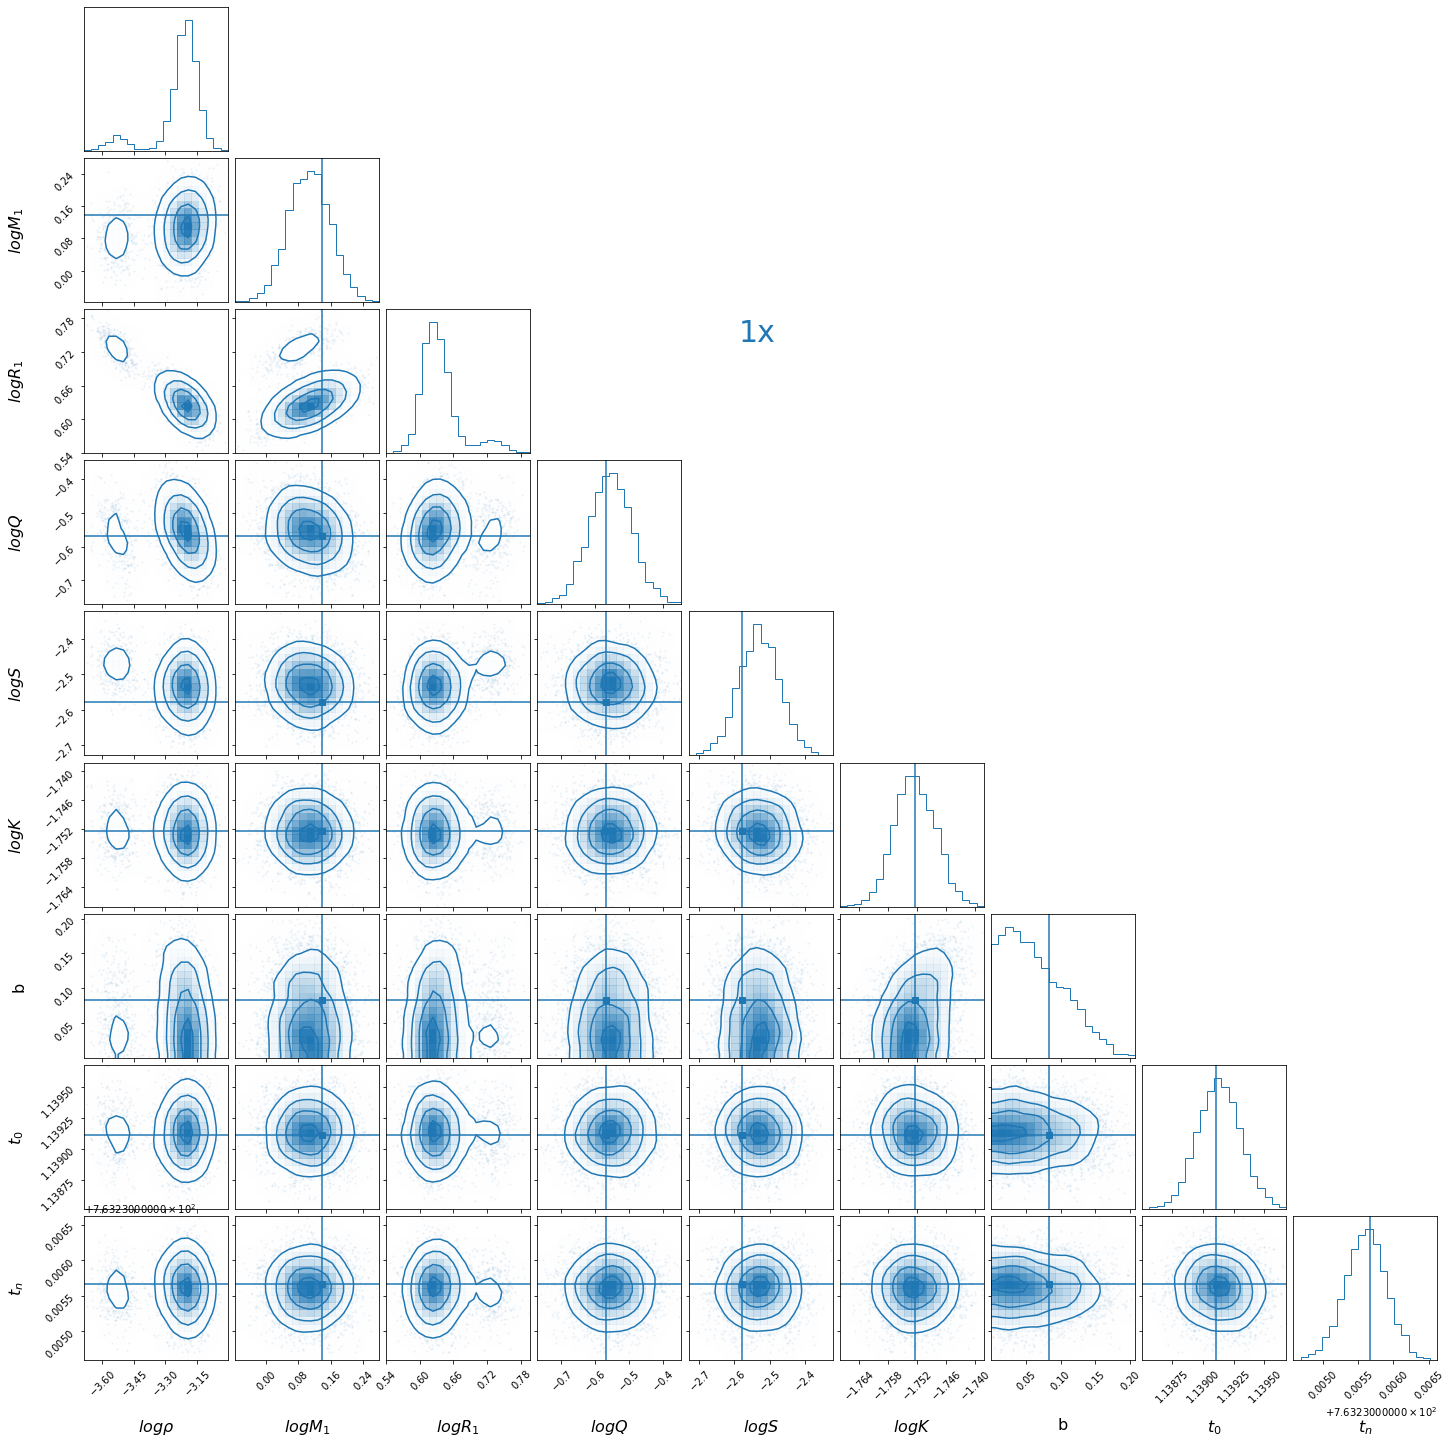

In [62]:
from helper_functions import *
plot_target = 'TIC 28159019'
plot_all_model_corners(plot_target, chains=8, Ntune=1000, Ndraw=500, model_list=['1x'])
plot_dest = f'/Users/kjaehnig/CCA_work/GAT/apotess_systems/{plot_target.replace(" ","_")}_files/figures/'
# plt.savefig(plot_dest+f"{plot_target}_four_MV_model_corner_plot.png", dpi=150, bbox_inches='tight')
plt.savefig(f"/Users/kjaehnig/CCA_work/GAT/apotess_systems/{plot_target.replace(' ','_')}_files/{plot_target.replace(' ','_')}_multi_model_post_corner.png",
            bbo_inches='tight', dpi=150)

In [19]:
def plot_LC_RV_phased_curves(TIC_TARGET, Ntune=1000, Ndraw=500, chains=4,
                                model_list=['diagonal','isotropized_isochrones','isochrones', 'diagonalized_isochrones'],
                            save_to_disk=False):
    
    
    fig, axes = plt.subplots(figsize=(10,10), ncols=1, nrows=2)

    for ii, model_type in enumerate(model_list):
        try:
            modcol = f"C{int((ii*3)+1)}"

            file = open(f"/Users/kjaehnig/CCA_work/GAT/pymc3_models/{TIC_TARGET}_pymc3_Nt{Ntune}_Nd{Ndraw}_Nc{chains}_individual_priors_{model_type}_isochrones.pickle",'rb')
            mv_res_dict = pk.load(file)
            file.close()

            flat_samps = mv_res_dict['trace'].posterior.stack(sample=('chain','draw'))
            x_rv = mv_res_dict['rvdat']['x_rv']
            y_rv = mv_res_dict['rvdat']['y_rv']
            yerr_rv = mv_res_dict['rvdat']['yerr_rv']

            x = mv_res_dict['lcdat']['x']
            y = mv_res_dict['lcdat']['y']
            yerr = mv_res_dict['lcdat']['yerr']

            gp_pred = mv_res_dict['gp_pred']

            trv = mv_res_dict['trv']
            tlc = mv_res_dict['tlc'] 

            rvvals = mv_res_dict['rvvals']
            lcvals = mv_res_dict['lcvals']

            p_med = flat_samps['period'].median().values
            t0_med = flat_samps['t0'].median().values
            mean_rv = flat_samps['mean_rv'].median().values
            mean_lc = flat_samps['mean_lc'].median().values
            # gp_pred = flat_samps['gp_pred'].median().values

            # print(flat_samps['ecc'].median())
            if ii == 0:
                axes[0].errorbar(hf.fold(x_rv, p_med, t0_med),
                          y_rv, yerr=yerr_rv, fmt=".k")
            # rvvals = indres['rvvals']
            # lcvals = indres['lcvals']

            t_fold = hf.fold(trv, p_med, t0_med)
            inds = np.argsort(t_fold)
            pred = np.percentile(rvvals, [16, 50, 84], axis=0)
            axes[0].plot(t_fold[inds], pred[1][inds], color=modcol, zorder=2)

            pred = np.percentile(rvvals, [16, 84], axis=0)
            art = axes[0].fill_between(t_fold[inds], pred[0][inds], pred[1][inds], color=modcol, alpha=0.5, zorder=1)
            art.set_edgecolor("none")

            pred = np.percentile(rvvals, [5, 95], axis=0)
            art = axes[0].fill_between(t_fold[inds], pred[0][inds], pred[1][inds], color=modcol, alpha=0.25, zorder=0)
            art.set_edgecolor("none")

            # pred = np.percentile(rvvals, [1, 99], axis=0)
            # art = axes[0].fill_between(t_fold, pred[0], pred[1], color='C1', alpha=0.10, zorder=0)
            # art.set_edgecolor("none")
            # axes[0].set_ylim(-40, 40)
            # axes[1].set_ylim(-40, 40)
            axes[0].set_ylabel("RV [kms]")

    #         x,y = extras['x'],extras['y']
            # with model:
            #     gp_pred = (
            #         pmx.eval_in_model(extras["gp_lc_pred"], post_map_soln)
            #     )

            if ii == 0:
                axes[1].errorbar(hf.fold(x, p_med, t0_med),
                          y-gp_pred, fmt=".k", ms=1, zorder=-1)

            t_fold = hf.fold(tlc, p_med, t0_med)
            inds = np.argsort(t_fold)
            pred = np.percentile(lcvals, [16, 50, 84], axis=0)
            axes[1].plot(t_fold[inds], pred[1][inds], color=modcol, zorder=2,label=model_type)

            pred = np.percentile(lcvals, [16, 84], axis=0)
            art = axes[1].fill_between(t_fold[inds], pred[0][inds], pred[1][inds], color=modcol, alpha=0.5, zorder=1)
            art.set_edgecolor("none")

            pred = np.percentile(lcvals, [5, 95], axis=0)
            art = axes[1].fill_between(t_fold[inds], pred[0][inds], pred[1][inds], color=modcol, alpha=0.25, zorder=0)
            art.set_edgecolor("none")

            # pred = np.percentile(flat_samps['lc_pred'][inds], [1, 99], axis=-1)
            # art = axes[1].fill_between(t_fold[inds], pred[0], pred[1], color='C1', alpha=0.10, zorder=0)
            # art.set_edgecolor("none")
            axes[1].legend()
            axes[1].set_xlabel("phase [days]")
            axes[1].set_ylabel("flux [ppt]")
            axes[0].set_title(TIC_TARGET)
        except:
            continue
    if save_to_disk:
        plt.savefig(f"/Users/kjaehnig/CCA_work/GAT/apotess_systems/{TIC_TARGET.replace(' ','_')}_files/multi_model_RV_LC_curves.png", bbox_inches='tight', dpi=150)
        

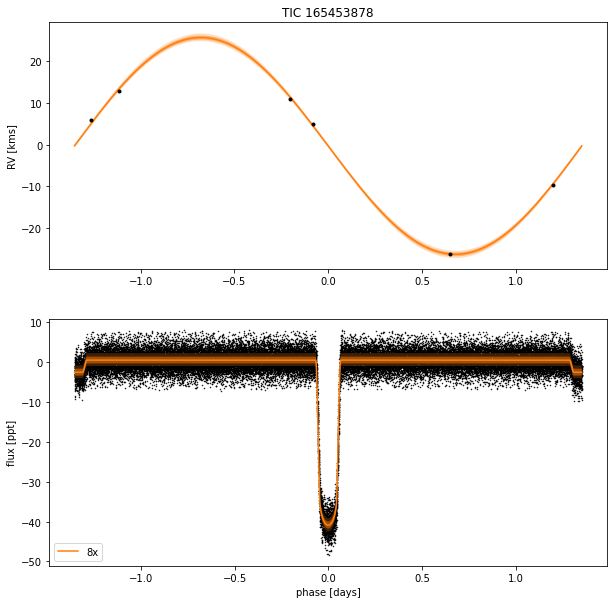

In [66]:
plot_target = 'TIC 165453878'
plot_LC_RV_phased_curves(plot_target, chains=8, Ntune=1000, Ndraw=500, model_list=['8x'], save_to_disk=True)

In [25]:
def plot_LC_RV_phased_curve_gallery(TIC_TARGETs=['TIC 20215452'], Ntune=1000, Ndraw=500, chains=4,
                                model_list=['1x'], save_to_disk=False, Ncols=4):
    
    nrows = 2 if len(TIC_TARGETs)/float(Ncols) <= 1.0 else 4
    fig, all_axes = plt.subplots(figsize=(20,15), ncols=min(Ncols, len(TIC_TARGETs)), nrows=nrows)

    for jj, ticid in enumerate(TIC_TARGETs):
        if len(TIC_TARGETs)==1:
            axes = all_axes
        else:
            if jj <= Ncols-1:
                axes = all_axes[:2,jj]
            if jj > Ncols-1:
                axes = all_axes[2:,jj-Ncols]
        #         print(axes)
        for ii, model_type in enumerate(model_list):

            modcol = f"C{int((ii*3)+1)}"
            try:
                file = open(f"/Users/kjaehnig/CCA_work/GAT/pymc3_models/{ticid}_pymc3_Nt{Ntune}_Nd{Ndraw}_Nc{chains}_individual_priors_{model_type}_isochrones.pickle",'rb')
                mv_res_dict = pk.load(file)
                file.close()

                flat_samps = mv_res_dict['trace'].posterior.stack(sample=('chain','draw'))
                x_rv = mv_res_dict['rvdat']['x_rv']
                y_rv = mv_res_dict['rvdat']['y_rv']
                yerr_rv = mv_res_dict['rvdat']['yerr_rv']

                x = mv_res_dict['lcdat']['x']
                y = mv_res_dict['lcdat']['y']
                yerr = mv_res_dict['lcdat']['yerr']

                gp_pred = mv_res_dict['gp_pred']

                trv = mv_res_dict['trv']
                tlc = mv_res_dict['tlc'] 

                rvvals = mv_res_dict['rvvals']
                lcvals = mv_res_dict['lcvals']

                p_med = flat_samps['period'].median().values
                t0_med = flat_samps['t0'].median().values
                mean_rv = flat_samps['mean_rv'].median().values
                mean_lc = flat_samps['mean_lc'].median().values
                # gp_pred = flat_samps['gp_pred'].median().values

                # print(flat_samps['ecc'].median())

                axes[0].errorbar(hf.fold(x_rv, p_med, t0_med),
                              y_rv, yerr=yerr_rv, fmt=".k")
                # rvvals = indres['rvvals']
                # lcvals = indres['lcvals']

                t_fold = hf.fold(trv, p_med, t0_med)
                inds = np.argsort(t_fold)
                pred = np.percentile(rvvals, [16, 50, 84], axis=0)
                axes[0].plot(t_fold[inds], pred[1][inds], color=modcol, zorder=2)

                pred = np.percentile(rvvals, [16, 84], axis=0)
                art = axes[0].fill_between(t_fold[inds], pred[0][inds], pred[1][inds], color=modcol, alpha=0.5, zorder=1)
                art.set_edgecolor("none")

                pred = np.percentile(rvvals, [5, 95], axis=0)
                art = axes[0].fill_between(t_fold[inds], pred[0][inds], pred[1][inds], color=modcol, alpha=0.25, zorder=0)
                art.set_edgecolor("none")

                # pred = np.percentile(rvvals, [1, 99], axis=0)
                # art = axes[0].fill_between(t_fold, pred[0], pred[1], color='C1', alpha=0.10, zorder=0)
                # art.set_edgecolor("none")
                # axes[0].set_ylim(-40, 40)
                # axes[1].set_ylim(-40, 40)
                axes[0].set_ylabel("RV [kms]")

        #         x,y = extras['x'],extras['y']
                # with model:
                #     gp_pred = (
                #         pmx.eval_in_model(extras["gp_lc_pred"], post_map_soln)
                #     )


                axes[1].errorbar(hf.fold(x, p_med, t0_med),
                              y-gp_pred, fmt=".k", ms=1, zorder=-1)

                t_fold = hf.fold(tlc, p_med, t0_med)
                inds = np.argsort(t_fold)
                pred = np.percentile(lcvals, [16, 50, 84], axis=0)
                axes[1].plot(t_fold[inds], pred[1][inds], color=modcol, zorder=2,label=model_type)

                pred = np.percentile(lcvals, [16, 84], axis=0)
                art = axes[1].fill_between(t_fold[inds], pred[0][inds], pred[1][inds], color=modcol, alpha=0.5, zorder=1)
                art.set_edgecolor("none")

                pred = np.percentile(lcvals, [5, 95], axis=0)
                art = axes[1].fill_between(t_fold[inds], pred[0][inds], pred[1][inds], color=modcol, alpha=0.25, zorder=0)
                art.set_edgecolor("none")

                # pred = np.percentile(flat_samps['lc_pred'][inds], [1, 99], axis=-1)
                # art = axes[1].fill_between(t_fold[inds], pred[0], pred[1], color='C1', alpha=0.10, zorder=0)
                # art.set_edgecolor("none")
                axes[1].legend(fontsize=12)
                axes[0].set_title(f"{ticid}")
                axes[1].set_xlabel("phase [days]")
                axes[1].set_ylabel("flux [ppt]")
            except:
                continue
    if save_to_disk:
        fig.subplots_adjust(hspace=0.30)
        plt.savefig(f"/Users/kjaehnig/CCA_work/GAT/{'_'.join(TIC_TARGETs).replace(' ','_')}_LC_curves.png", bbox_inches='tight', dpi=150)
    return (fig,all_axes)
    
tic_systems_of_interest = [
    28159019,
    272074664,
    20215452,
    99254945,
    144441148,
    169820068,
    126232983,
    164458426,
    164527723,
    165453878,
    258108067,
    271548206,
    365204192
    ]

(<Figure size 1440x1080 with 12 Axes>,
 array([[<AxesSubplot:title={'center':'TIC 28159019'}, ylabel='RV [kms]'>,
         <AxesSubplot:>,
         <AxesSubplot:title={'center':'TIC 20215452'}, ylabel='RV [kms]'>,
         <AxesSubplot:title={'center':'TIC 99254945'}, ylabel='RV [kms]'>,
         <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:xlabel='phase [days]', ylabel='flux [ppt]'>,
         <AxesSubplot:>,
         <AxesSubplot:xlabel='phase [days]', ylabel='flux [ppt]'>,
         <AxesSubplot:xlabel='phase [days]', ylabel='flux [ppt]'>,
         <AxesSubplot:>, <AxesSubplot:>]], dtype=object))

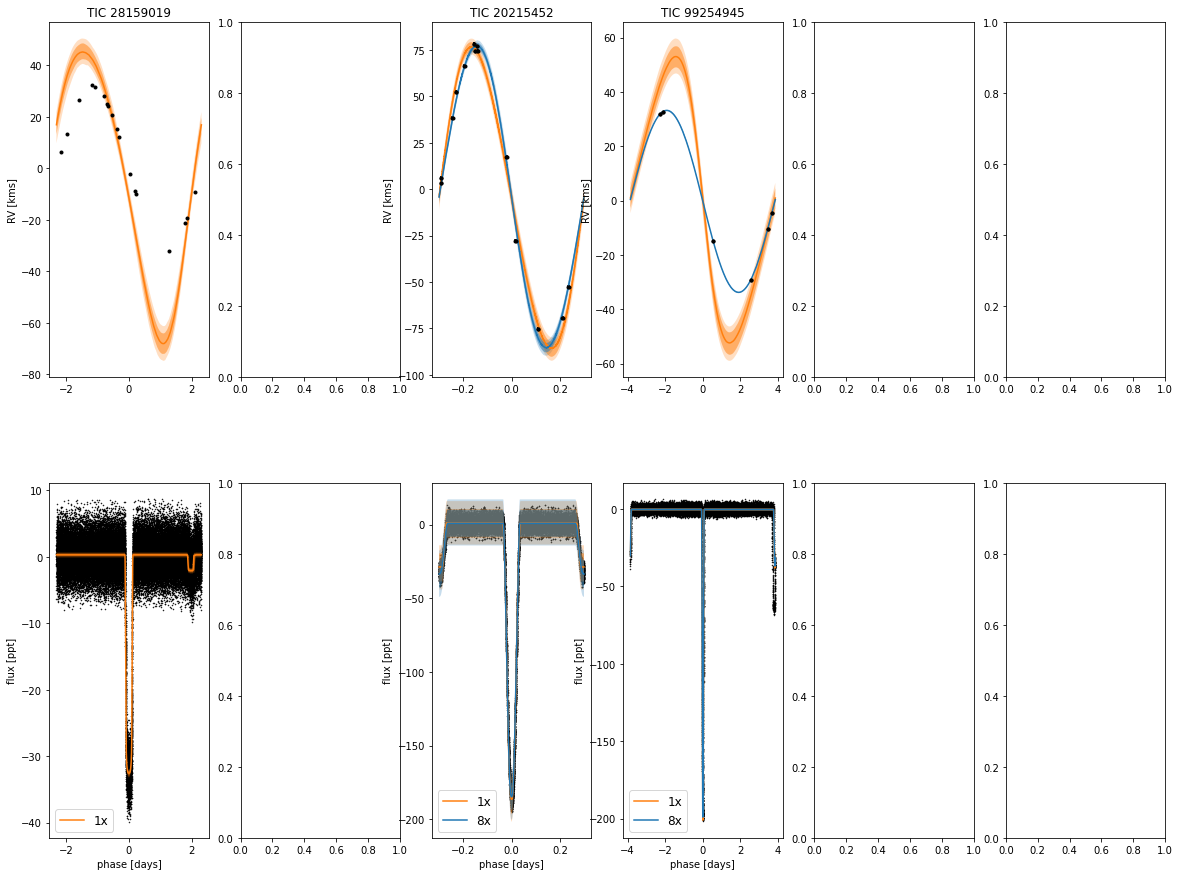

In [67]:
plot_targets = [f'TIC {id}' for id in tic_systems_of_interest[:6]]
# plot_targets = [f'TIC {id}' for id in ['20215452','164458426','165453878','258108067','271548206']]
plot_LC_RV_phased_curve_gallery(plot_targets, chains=8, Ntune=1000, Ndraw=500, model_list=['1x','2x','4x','8x'],save_to_disk=True,Ncols=6)

(<Figure size 1440x1080 with 14 Axes>,
 array([[<AxesSubplot:title={'center':'TIC 126232983'}, ylabel='RV [kms]'>,
         <AxesSubplot:>,
         <AxesSubplot:title={'center':'TIC 164527723'}, ylabel='RV [kms]'>,
         <AxesSubplot:title={'center':'TIC 165453878'}, ylabel='RV [kms]'>,
         <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:xlabel='phase [days]', ylabel='flux [ppt]'>,
         <AxesSubplot:>,
         <AxesSubplot:xlabel='phase [days]', ylabel='flux [ppt]'>,
         <AxesSubplot:xlabel='phase [days]', ylabel='flux [ppt]'>,
         <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]], dtype=object))

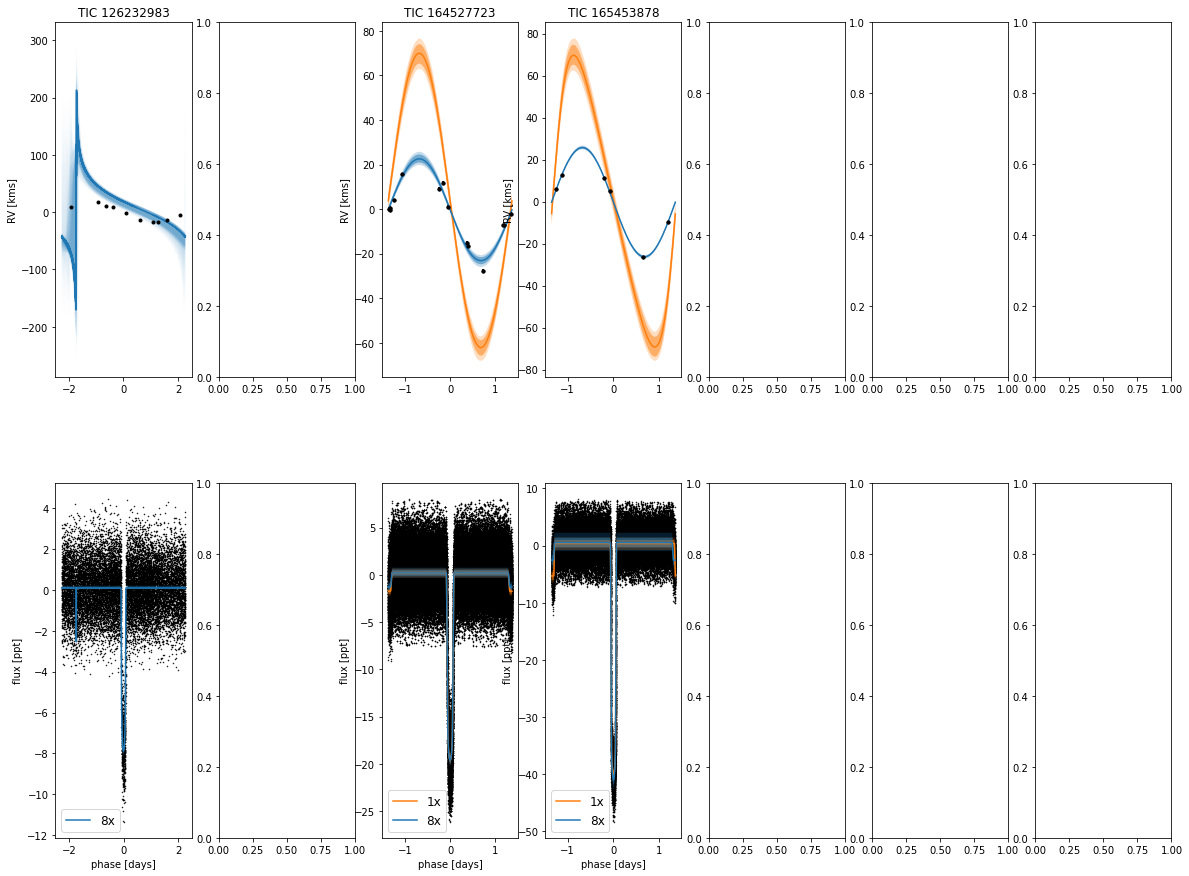

In [68]:
plot_targets = [f'TIC {id}' for id in tic_systems_of_interest[6:]]
# plot_targets = [f'TIC {id}' for id in ['20215452','164458426','165453878','258108067','271548206']]
plot_LC_RV_phased_curve_gallery(plot_targets, chains=8, Ntune=1000, Ndraw=500, model_list=['1x','2x','4x','8x'],save_to_disk=True,Ncols=7)

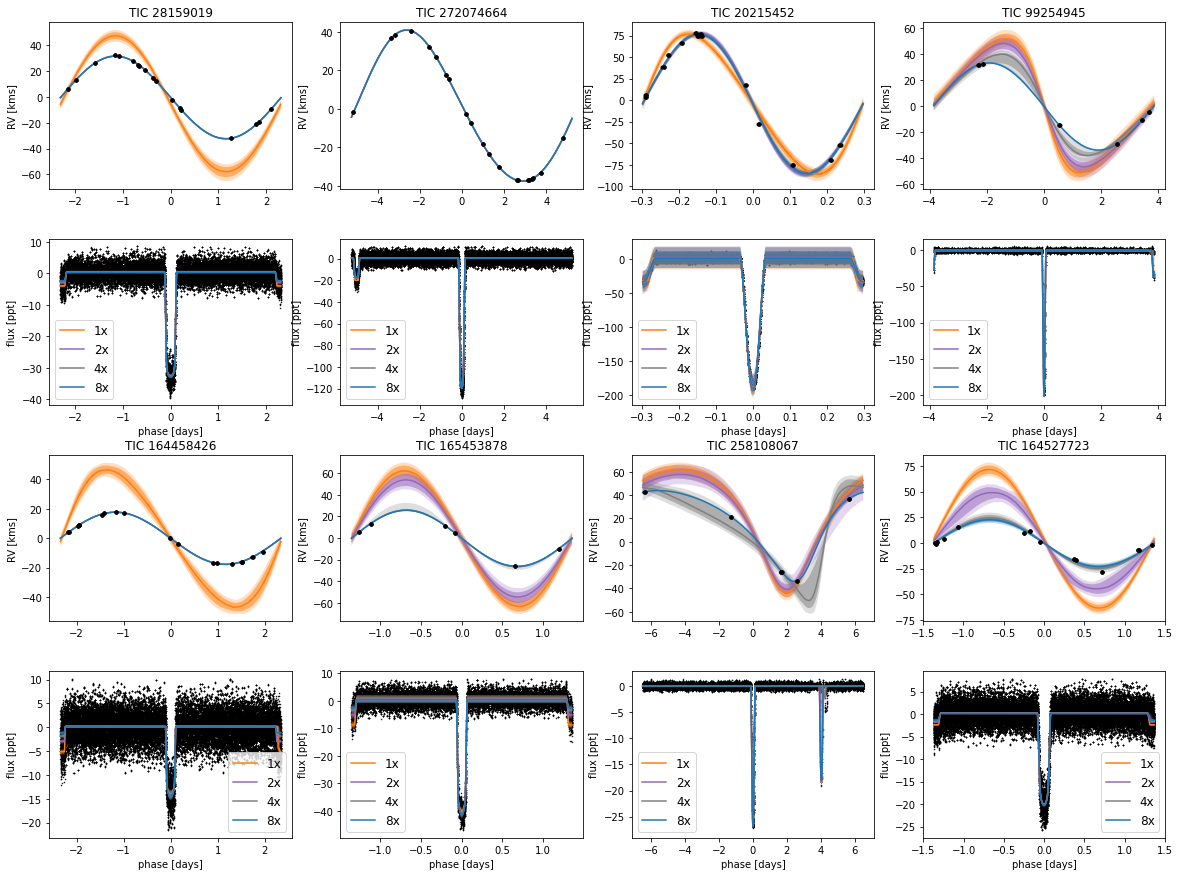

In [24]:
good_tic_systems_of_interest = [
    28159019,
    272074664,
    20215452,
    99254945,
    164458426,
    165453878,
    258108067,
    164527723,
    ]
plot_targets = [f'TIC {id}' for id in good_tic_systems_of_interest]
# plot_targets = [f'TIC {id}' for id in ['20215452','164458426','165453878','258108067','271548206']]
fig,all_axes = plot_LC_RV_phased_curve_gallery(plot_targets, chains=6, Ntune=1000, Ndraw=500, model_list=['1x','2x','4x','8x'],save_to_disk=True, Ncols=4)



In [56]:
def plot_3panel_LC_plot_gallery(TIC_TARGETs=['TIC 20215452'], Ntune=1000, Ndraw=500, chains=4,
                                model_list=['1x'], save_to_disk=False):
    
    
    fig, all_axes = plt.subplots(figsize=(20,16), ncols=len(TIC_TARGETs), nrows=3, sharex=True)

    for jj, ticid in enumerate(TIC_TARGETs):
        if len(TIC_TARGETs)==1:
            axes = all_axes
        else:
            axes = all_axes[:,jj]
        
#         print(axes)
        for ii, model_type in enumerate(model_list):

            modcol = 'red'#f"C{int((ii*0)+1)}"
            
            file = open(f"/Users/kjaehnig/CCA_work/GAT/pymc3_models/{ticid}_pymc3_Nt{Ntune}_Nd{Ndraw}_Nc{chains}_individual_priors_{model_type}_isochrones.pickle",'rb')
            mv_res_dict = pk.load(file)
            file.close()

            flat_samps = mv_res_dict['trace'].posterior.stack(sample=('chain','draw'))
            x_rv = mv_res_dict['rvdat']['x_rv']
            y_rv = mv_res_dict['rvdat']['y_rv']
            yerr_rv = mv_res_dict['rvdat']['yerr_rv']

            x = mv_res_dict['lcdat']['x']
            y = mv_res_dict['lcdat']['y']
            yerr = mv_res_dict['lcdat']['yerr']

            gp_pred = mv_res_dict['gp_pred']

            trv = mv_res_dict['trv']
            tlc = mv_res_dict['tlc'] 

            rvvals = mv_res_dict['rvvals']
            lcvals = mv_res_dict['lcvals']

            p_med = flat_samps['period'].median().values
            t0_med = flat_samps['t0'].median().values
            mean_rv = flat_samps['mean_rv'].median().values
            mean_lc = flat_samps['mean_lc'].median().values

            
            pred = np.percentile(lcvals, [16, 50, 84], axis=0)


            print(p_med)
            hp = 1. * p_med


            ### first subplot - the unfolded time series with model
            #### (tn - t0) / Ntrans = PERIOD; tn = (period*Ntrans) + t0
#             tn_med = (p_med * 0) + t0_med
            
            axes[0].errorbar((x - t0_med), y, yerr=yerr, fmt=".k",ecolor='gray', zorder=-1)
            axes[0].plot(x-t0_med, gp_pred, ls='--', color='gold',lw=3)
            axes[0].plot(tlc-t0_med, pred[1], color=modcol, zorder=2,lw=2)

  
            
            axes[0].set_xlim(-.5*hp, +.5*hp) 
            
            xlim1 = axes[0].set_xlim()
            ylim1 = axes[0].set_ylim()
            
            axes[0].text(0.95 * xlim1[1], 0.95*ylim1[1],
                         "unfolded lightcurve",
                         horizontalalignment='right',
                         verticalalignment='top', fontsize=16)
            # rvvals = indres['rvvals']
            # lcvals = indres['lcvals']

            t_fold = fold(x, hp, t0_med)
#             t_fold = (x - t0_med + hp) % p_med - hp
            inds = np.argsort(t_fold)
            axes[1].errorbar(t_fold,
                          y, fmt=".k", ms=1, yerr=yerr, zorder=-1, ecolor='gray')
            axes[1].plot(t_fold[inds], gp_pred[inds], ls='--', color='gold')
#             axes[1].set_xlim(-t0_med, t0_med)
#             axes[1].set_xlim(-t0_med, t0_med) 

#             t_fold = (tlc - t0_med + hp) % p_med - hp
            t_fold = fold(tlc, p_med, t0_med)
            inds = np.argsort(t_fold)
            axes[1].plot(t_fold[inds], pred[1][inds], color=modcol, zorder=2,lw=2)

            axes[1].text(0.95 * xlim1[1], 0.95*ylim1[1],
                         "folded lightcurve, no GP subtraction",
                         horizontalalignment='right',
                         verticalalignment='top', fontsize=16)
            
            
#             t_fold = (x - t0_med + hp) % p_med - hp 
            t_fold = fold(x, hp, t0_med)
            inds = np.argsort(t_fold)
            axes[2].errorbar(t_fold[inds],
                          y[inds]-gp_pred[inds], fmt=".k", yerr=yerr, ms=1, zorder=-1, ecolor='gray')

#             t_fold = (tlc - t0_med + hp) % p_med - hp
            t_fold = hf.fold(tlc, hp, t0_med)
            inds = np.argsort(t_fold)
            pred = np.percentile(lcvals, [16, 50, 84], axis=0)
            axes[2].plot(t_fold[inds], pred[1][inds], color=modcol, zorder=2, lw=2)
            
            xlim1 = axes[2].set_xlim()
            ylim1 = axes[2].set_ylim()
            axes[2].text(0.95 * xlim1[1], 0.95*ylim1[1],
                         "folded lightcurve, full GP subtraction",
                         horizontalalignment='right',
                         verticalalignment='top', fontsize=16)

            axes[0].set_title(f"{ticid}")
            axes[0].set_ylabel("flux [ppt]")
            axes[1].set_ylabel("flux [ppt]")
            axes[2].set_ylabel("flux [ppt]")
            axes[2].set_xlabel("phase [days]")
    fig.subplots_adjust(hspace=0.0)
    if save_to_disk:
        plt.savefig(f"/Users/kjaehnig/CCA_work/GAT/{'_'.join(TIC_TARGETs).replace(' ','_')}_LC_curves.png", bbox_inches='tight', dpi=150)
        

2.707599959175035


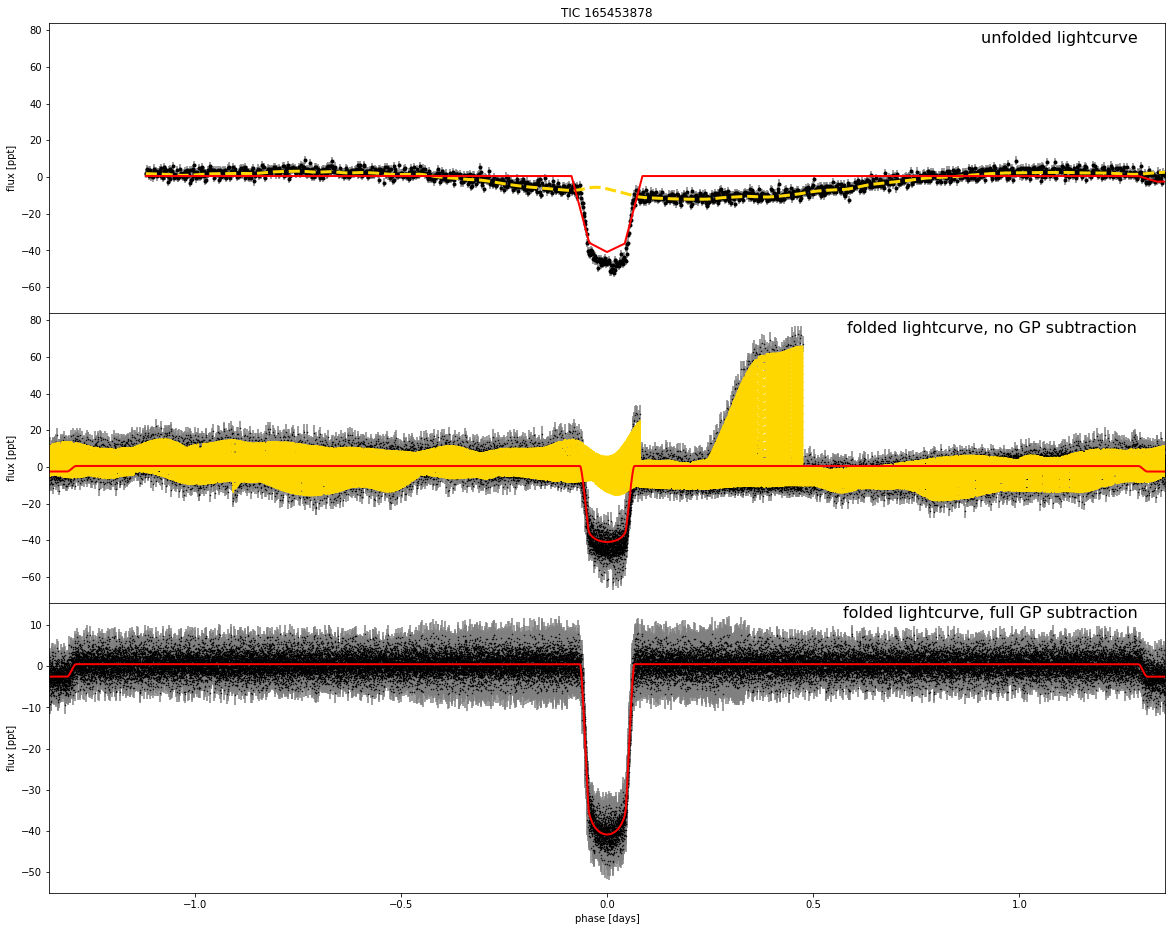

In [58]:
plot_3panel_LC_plot_gallery(TIC_TARGETs=['TIC 165453878'], Ntune=1000, Ndraw=500, chains=8, model_list=['8x'], save_to_disk=True)